# Library

***Install Library untuk membaca data***

In [1]:
pip install librosa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
pip install audiolazy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 KB 10.7 MB/s eta 0:00:00


***Import library yang akan digunakan***

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.signal as sp
import librosa as lbr
import IPython.display as ipd
import scipy.signal as sig
import scipy.linalg as linalg
import scipy 
import torch
import os

from scipy.fftpack import dct
from numpy.lib import npyio
from audiolazy import *

***menghubungkan colabs dengan Gdrive***

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Read Data

## Playing

In [5]:
def bacadata(mp):
  signal,sr  = lbr.load(mp,duration=8,sr=16000)
  return signal,sr

In [6]:
folder = '/content/drive/MyDrive/genderclassification/Data suara/'  #path data
amount = 45                                                         #jumlah data

for x in range(1,int(amount)+1):
  mp = folder+str(x)+'.mp3'                                         #menentukan format data.mp3
  signal,sr = bacadata(mp)                                          #menampilkan data suara yang diinput
  display(ipd.Audio(signal,rate=sr)) 

Output hidden; open in https://colab.research.google.com to view.

## Before Cleaning

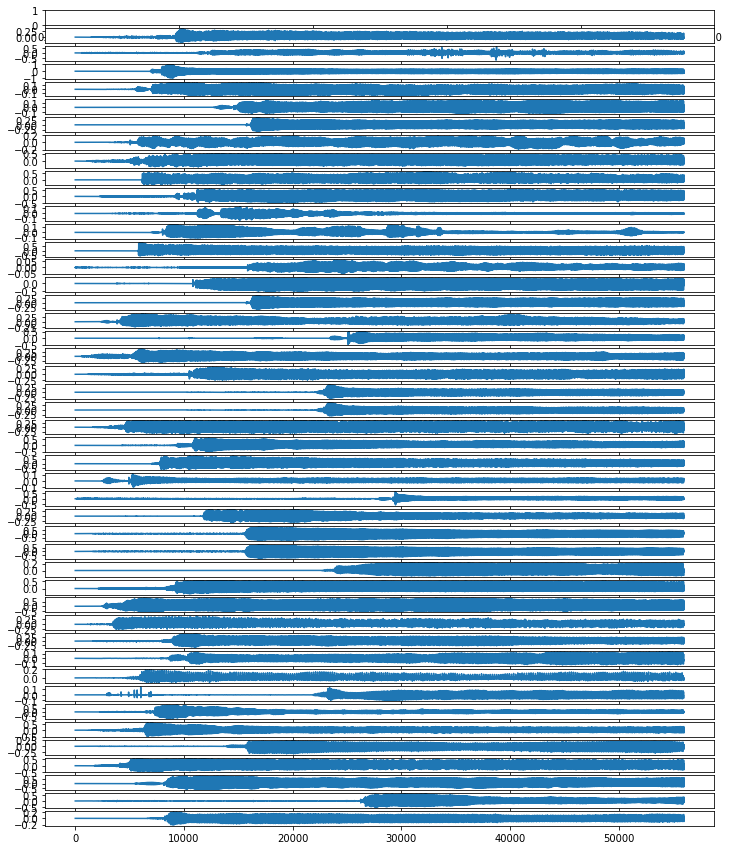

In [7]:
folder = '/content/drive/MyDrive/genderclassification/Data suara/'
amount = 45

fig, axes = plt.subplots(46,1, figsize=(12, 15))
for x in range(1,int(amount)+1):
  mp = folder+str(x)+'.mp3'
  signal,sr = bacadata(mp)
  signal = signal[0:int(3.5 * sr)]
  axes[x].plot(signal)

## After Cleaning

*Didapatkan bahwa tidak seluruhnya x signal dipenuhi maka akan dilakukan pemotongan noise pada setiap data*

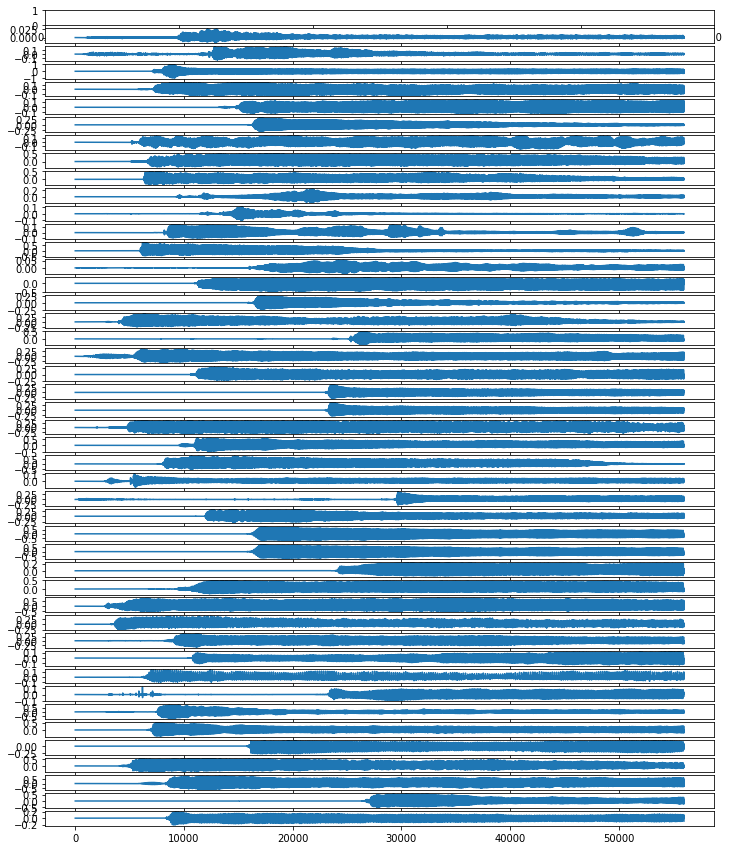

In [8]:
folder = '/content/drive/MyDrive/genderclassification/Data clean/' #data sebelum pemotongan noise
amount = 45

fig, axes = plt.subplots(46,1, figsize=(12, 15))
for x in range(1,int(amount)+1):
  mp = folder+str(x)+'.mp3'
  signal,sr = bacadata(mp)
  signal = signal[0:int(3.5 * sr)]
  axes[x].plot(signal)

# Mel Frequency Cepstral Coefficient

## Proses Ekstraksi Ciri MFCC

`set timing data dengan frekuensi 16000Hz`

In [9]:
def initialize(mp):
  signal,sr = lbr.load(mp,duration=8,sr=16000)
  signal = signal[0:int(3.5 * sr)]
  return sr,signal

`Membangun Fungsi LPF`

*dimana LPF akan menyaring sinyal frekuensi tinggi dan meneruskan sinyal frekuensi rendah yang diinginkan*

In [10]:
def lowPassFilter(signal, pre_emphasis=0.97):
	return np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])

`Melakukan Teknik Filter PreEmphasis`

Proses pre-emphasis mempertajam fitur suara pada frekuensi tinggi sehingga dapat meningkatkan kemampuan sistem pengenalan suara untuk mengenali suara manusia // mendapatkan bentuk spectral frekuensi sinyal yang lebih halus

In [11]:
def preEmphasis(mp):
	sr,signal = initialize(mp)										
	pre_emphasis=0.97														
	emphasizedSignal = lowPassFilter(signal)				
	return emphasizedSignal

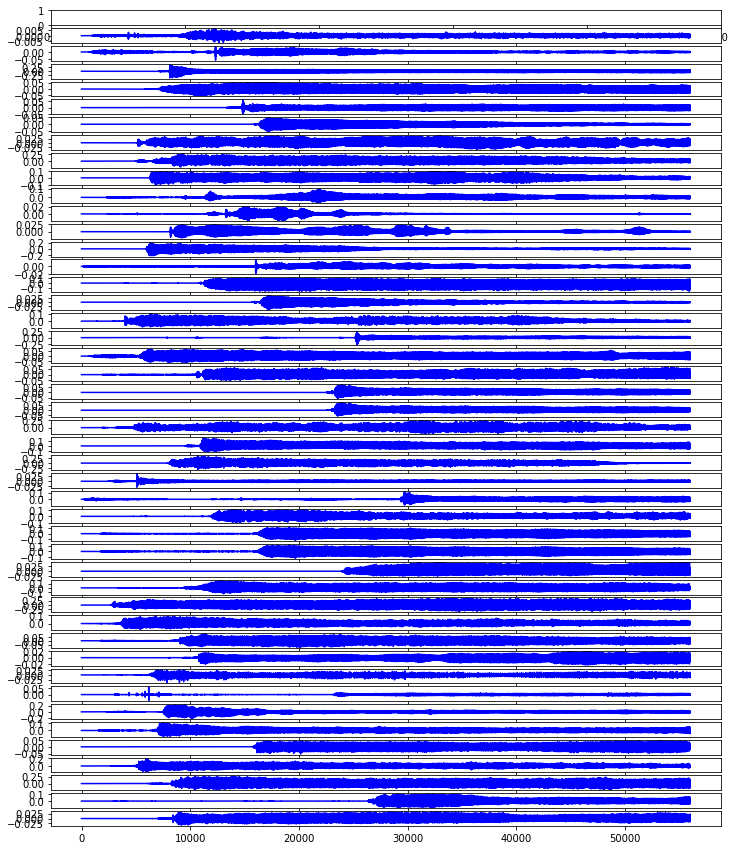

In [12]:
pre_emphasis = 0.97
fig, axes = plt.subplots(46,1, figsize=(12, 15))

for x in range(1,int(amount)+1):
  mp = folder+str(x)+'.mp3'
  signal,sr = bacadata(mp)
  signal = signal[0:int(3.5 * sr)]
  emphasized_signal = lowPassFilter(signal)
  axes[x].plot(emphasized_signal, c='b')

Framing adalah proses membagi sinyal suara menjadi beberapa segmen atau frame yang lebih kecil dengan ukuran yang sama,

frame-frame tersebut kemudian diberikan overlap dan diaplikasikan fungsi jendela (window function) seperti hamming window atau hanning window untuk meminimalkan efek distorsi yang terjadi di pinggiran frame // *OVERLAP = memberikan hasil spektrum MFCC yang akan berkorelasi tiap bagiannya*

In [13]:
def framing(mp):	
    windowSize = 0.75			
    windowStep = 0.01				
    sr, signal = initialize(mp)
    frame_length, frame_step = windowSize * sr, windowStep * sr
    signal_length = len(preEmphasis(mp))
    overlap = int(round(frame_length)) 
    frameSize = int(round(frame_step)) 
    numberOfframes = int(np.ceil(float(np.abs(signal_length - frameSize)) / overlap ))
    pad_signal_length = numberOfframes * frameSize + overlap
    if pad_signal_length >= signal_length:
        z = np.zeros((pad_signal_length - signal_length))
        pad_signal = np.append(preEmphasis(mp), z)
    else:
        pad_signal = preEmphasis(mp)

    indices = np.tile(np.arange(0, overlap), (numberOfframes, 1)) + np.tile(np.arange(0, 
                numberOfframes * frameSize, frameSize), (overlap, 1)).T
    frames = pad_signal[indices.astype(np.int32, copy=False)]
    frames *= np.hamming(frame_length)
    return frames

Setelah itu, setiap frame dihitung nilai spektrum daya melalui transformasi Fourier cepat (FFT) untuk menghasilkan spektrum frekuensi yang kemudian akan dihitung koefisien cepstral frekuensi mel (MFCC)

In [14]:
def fouriertransform(mp):				
	NFFT = 512
	frames = framing(mp)
	mag_frames = np.absolute(np.fft.rfft(frames, NFFT))  
	pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  
	return pow_frames

melakukan teknik filterbanks, digunakan untuk mengubah domain waktu sinyal suara menjadi domain frekuensi, menyaring frekuensi yang kurang informatif dan mempertahankan informasi yang paling penting

In [15]:
def filterbanks(mp):
  nfilt = 40
  low_freq_mel = 0
  NFFT = 512

  sr, signal = initialize(mp)
  high_freq_mel = (2595 * np.log10(1 + (sr / 2) / 700))  
  mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  
  hz_points = (700 * (10**(mel_points / 2595) - 1))  
  bin = np.floor((NFFT + 1) * hz_points / sr)

  pow_frames = fouriertransform(mp)
  fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
  for m in range(1, nfilt + 1):
      f_m_minus = int(bin[m - 1])   
      f_m = int(bin[m])             
      f_m_plus = int(bin[m + 1])    

      for k in range(f_m_minus, f_m):
          fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
      for k in range(f_m, f_m_plus):
          fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
  filter_banks = np.dot(pow_frames, fbank.T)
  filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  
  filter_banks = 20 * np.log10(filter_banks) 
  
  return filter_banks

## Hasil Ekstraksi

In [16]:
def	mfcc(mp):
	num_ceps = 12
	cep_lifter = 22
	filter_banks = filterbanks(mp)
	mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)] # Keep 2-13
	(nframes, ncoeff) = mfcc.shape
	n = np.arange(ncoeff)
	lift = 1 + (cep_lifter / 2) * np.sin(np.pi * n / cep_lifter)
	mfcc *= lift
	mfcc = np.mean(mfcc, axis=0)
	return mfcc

In [17]:
folder = '/content/drive/MyDrive/genderclassification/Data clean/'
amount = 45
df = []

for x in range(1,int(amount)+1):
	mp = folder+str(x)+'.mp3'
	df.append(mfcc(mp))
 
data = pd.DataFrame(df)
data.replace(0, pd.np.nan, inplace=True)
data.dropna(inplace=True)
data = data.add_prefix('prefix_')
data

<ipython-input-17-3bf93edd7948>:10: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  data.replace(0, pd.np.nan, inplace=True)


,prefix_0,prefix_1,prefix_2,prefix_3,prefix_4,prefix_5,prefix_6,prefix_7,prefix_8,prefix_9,prefix_10,prefix_11
0,-90.459777,-27.874118,-88.976380,-45.780173,-20.476625,3.668026,-0.124708,-57.538753,9.792860,11.293169,-32.614399,-119.478459
1,-30.934670,-81.305394,-24.082840,15.835797,-57.115247,-70.875609,-38.009684,-138.972634,-35.305641,-76.268110,-62.232399,-27.163500
2,-85.147017,-14.499410,7.127770,-30.595191,13.966599,46.514976,-27.043965,-17.262343,-141.485907,-5.822673,15.424589,-155.224552
3,-134.815417,-40.573860,-33.070166,-23.784960,-3.438118,-135.612969,-104.260436,17.550823,81.423431,-25.889099,-57.716794,28.595740
5,-93.888364,-33.351761,-104.401930,9.138786,-154.631261,-80.826013,-42.234302,-18.975327,-139.969896,-82.004791,-6.967563,-99.261829
6,-81.093868,-53.608338,-65.811388,7.352948,-46.722548,-45.233575,93.492030,-131.944270,-141.007133,8.214800,-4.450687,-134.721989
7,-102.104747,-63.910141,-59.830540,2.331226,-91.915235,-21.917871,-123.565540,58.168405,103.275760,-85.592229,-106.913769,6.767815
8,-144.641056,-84.971993,-125.238768,-50.500711,-35.707842,-85.045390,-41.771826,-39.893416,-3.978930,-79.454368,-43.785071,-81.424852
9,-90.599389,-37.436464,-134.154526,-8.823457,-43.201541,-66.628652,-79.978922,-96.465309,-5.293320,-3.185211,-88.741696,-33.341523
10,-88.776260,-110.762390,-101.571382,-62.595363,-20.333995,-114.070318,-40.036297,-78.530856,61.308812,-107.757336,37.567582,-70.289334


## Menambahkan Variabel Gender

In [18]:
data['gender'] = ['Cewek','Cewek','Cewek','Cewek','Cewek','Cewek','Cewek','Cewek','Cewek','Cewek','Cewek','Cewek','Cewek','Cewek','Cewek','Cewek','Cewek',
                  'Cewek','Cewek','Cewek','Cewek','Cewek','Cewek','Cowok','Cowok','Cowok','Cowok','Cowok','Cowok','Cowok','Cowok','Cowok','Cowok','Cowok']
data

,prefix_0,prefix_1,prefix_2,prefix_3,prefix_4,prefix_5,prefix_6,prefix_7,prefix_8,prefix_9,prefix_10,prefix_11,gender
0,-90.459777,-27.874118,-88.976380,-45.780173,-20.476625,3.668026,-0.124708,-57.538753,9.792860,11.293169,-32.614399,-119.478459,Cewek
1,-30.934670,-81.305394,-24.082840,15.835797,-57.115247,-70.875609,-38.009684,-138.972634,-35.305641,-76.268110,-62.232399,-27.163500,Cewek
2,-85.147017,-14.499410,7.127770,-30.595191,13.966599,46.514976,-27.043965,-17.262343,-141.485907,-5.822673,15.424589,-155.224552,Cewek
3,-134.815417,-40.573860,-33.070166,-23.784960,-3.438118,-135.612969,-104.260436,17.550823,81.423431,-25.889099,-57.716794,28.595740,Cewek
5,-93.888364,-33.351761,-104.401930,9.138786,-154.631261,-80.826013,-42.234302,-18.975327,-139.969896,-82.004791,-6.967563,-99.261829,Cewek
6,-81.093868,-53.608338,-65.811388,7.352948,-46.722548,-45.233575,93.492030,-131.944270,-141.007133,8.214800,-4.450687,-134.721989,Cewek
7,-102.104747,-63.910141,-59.830540,2.331226,-91.915235,-21.917871,-123.565540,58.168405,103.275760,-85.592229,-106.913769,6.767815,Cewek
8,-144.641056,-84.971993,-125.238768,-50.500711,-35.707842,-85.045390,-41.771826,-39.893416,-3.978930,-79.454368,-43.785071,-81.424852,Cewek
9,-90.599389,-37.436464,-134.154526,-8.823457,-43.201541,-66.628652,-79.978922,-96.465309,-5.293320,-3.185211,-88.741696,-33.341523,Cewek
10,-88.776260,-110.762390,-101.571382,-62.595363,-20.333995,-114.070318,-40.036297,-78.530856,61.308812,-107.757336,37.567582,-70.289334,Cewek


<Axes: >

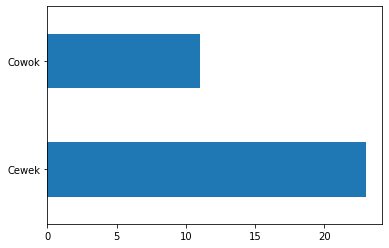

In [19]:
data['gender'].value_counts().plot(kind='barh')

# Analisis Data Eksploratif

In [20]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
prefix_0,34.0,-95.171639,37.947286,-151.213180,-131.692680,-90.774873,-78.546386,-1.237970
prefix_1,34.0,-63.220274,50.184341,-197.311957,-104.167562,-51.693422,-27.573052,7.465199
prefix_2,34.0,-69.517824,47.266784,-153.363462,-104.281863,-67.817998,-32.313952,12.122229
prefix_3,34.0,-31.428417,51.715167,-118.001747,-65.276660,-38.603926,6.375443,128.053435
prefix_4,34.0,-58.763895,62.137348,-190.106179,-109.111300,-40.596059,-15.147960,30.503455
prefix_5,34.0,-63.186980,64.116778,-222.309922,-93.972936,-63.269323,-17.137598,46.514976
prefix_6,34.0,-51.802425,64.551280,-212.322720,-99.792144,-47.728888,-12.921094,93.492030
prefix_7,34.0,-51.349117,63.761887,-227.032237,-78.353341,-42.554896,-17.690589,79.842557
prefix_8,34.0,-18.935042,79.471448,-183.062547,-64.032200,-18.508135,46.125434,120.128743
prefix_9,34.0,-45.118977,49.897812,-163.173110,-78.657803,-37.938297,-11.715923,54.479362


`Cek Normalisasi Data`

<ipython-input-21-e364ee4df1ae>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[data.columns[i]],color='green')
<ipython-input-21-e364ee4df1ae>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[data.columns[i]],color='green')
<ipython-input-21-e364ee4df1ae>:6: UserWarning: 

`distplot`

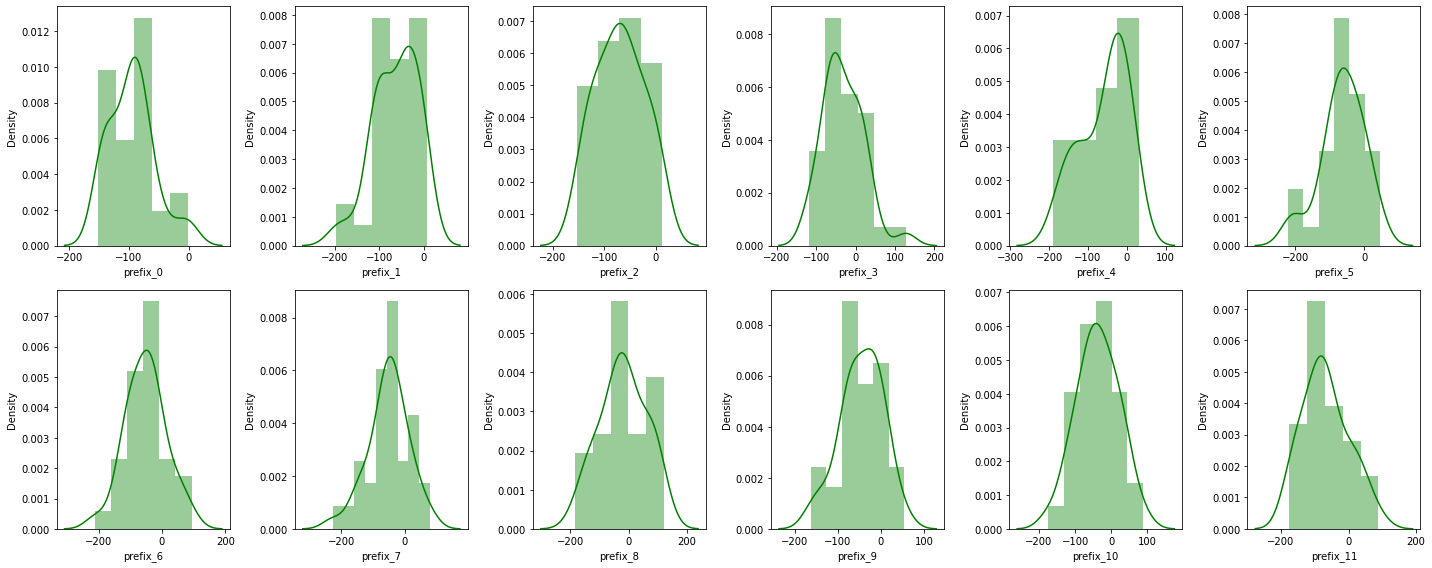

In [21]:
mfcc_data = data.drop('gender',axis=1)

plt.figure(figsize=(20,8))
for i in range(0,len(mfcc_data.columns)):
  plt.subplot(2,6,i+1)
  sns.distplot(data[data.columns[i]],color='green')
  plt.tight_layout()

`Cek Korelasi`

<Axes: >

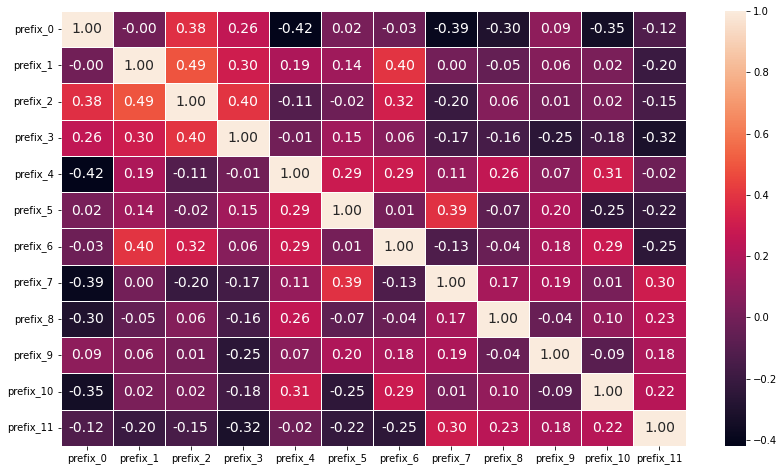

In [22]:
f,ax = plt.subplots(figsize=(14,8))
sns.heatmap(data.corr(), annot=True, annot_kws={"size": 14}, linewidths=.5, fmt= '.2f',ax=ax)

`Data Proportion`

In [23]:
numerik_data = data.select_dtypes(include=[np.number])
kategorik_data = data.select_dtypes(exclude=[np.number])
print(numerik_data.shape)
print(kategorik_data.shape)

(34, 12)
(34, 1)


*membagi proporsi data train 70% dan data test 30%*

In [65]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    numerik_data, 
    kategorik_data, 
    test_size = 0.30,  #proporsi
    random_state = 20) #set acakan data

In [66]:
y_train.value_counts()

gender
Cewek     15
Cowok      8
dtype: int64

In [67]:
y_test.value_counts()

gender
Cewek     8
Cowok     3
dtype: int64

# Model k-Nearest Neighbor (KNN)

## Train Model

In [68]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score

*membuat data target menjadi bentuk label encoding*

In [69]:
lb = LabelEncoder()
lb.fit(y_train)

y_train = lb.transform(y_train)
y_test = lb.transform(y_test)

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


*melakukan standarisasi pada variabel prediktor*

In [70]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

*membangun model dengan membandingkan nilai k looping for (1 <= k <= 20)*

In [71]:
test_skor = []
train_skor = []
accuracy = []

for i in range(1,21):

    knn = KNeighborsClassifier(i, metric='euclidean')
    knn.fit(X_train,y_train)
    
    y_pred = knn.predict(X_test)
    train_skor.append(knn.score(X_train,y_train))
    test_skor.append(knn.score(X_test,y_test))
    accuracy.append(accuracy_score(y_test, y_pred))

## Visualisasi Model

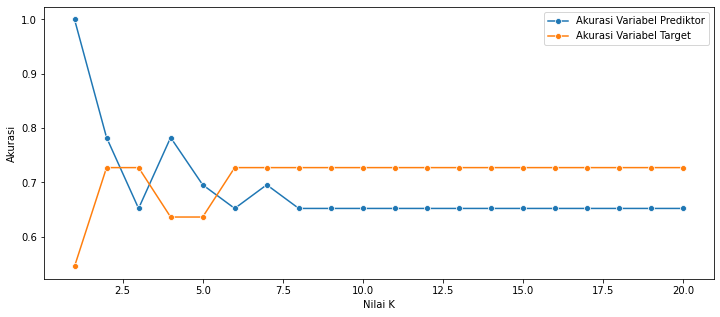

In [72]:
plt.figure(figsize=(12,5))
p = sns.lineplot(x=range(1, 21),y=train_skor, marker='o',label='Akurasi Variabel Prediktor')
p = sns.lineplot(x=range(1, 21),y=test_skor,marker='o',label='Akurasi Variabel Target')
plt.xlabel('Nilai K')
plt.ylabel('Akurasi')
plt.show()

## Evaluasi Model

Text(0, 0.5, 'Rata-Rata Accuracy')

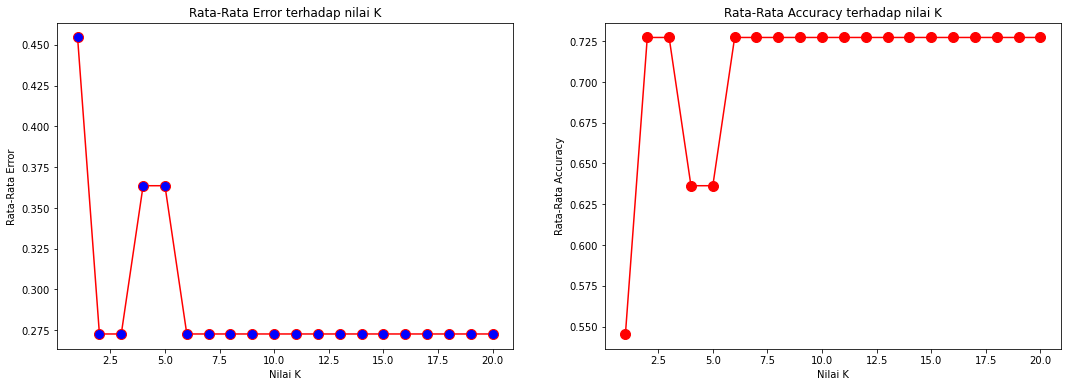

In [73]:
mean_error = []
mean_accuracy = []

for i in range(1, 21):
    knn = KNeighborsClassifier(n_neighbors=i, metric='euclidean')
    knn.fit(X_train, y_train)

    pred_i = knn.predict(X_test)
    mean_error.append(np.mean(pred_i != y_test))
    mean_accuracy.append(1-np.mean(pred_i != y_test))

fig = plt.figure(figsize=(18, 6))

plt.subplot(121)
plt.plot(range(1, 21), mean_error, color='red', marker='o',markerfacecolor='blue', markersize=10)
plt.title('Rata-Rata Error terhadap nilai K')
plt.xlabel('Nilai K')
plt.ylabel('Rata-Rata Error')

plt.subplot(122)
plt.plot(range(1, 21), mean_accuracy, color='red', marker='o',markerfacecolor='red', markersize=10)
plt.title('Rata-Rata Accuracy terhadap nilai K')
plt.xlabel('Nilai K')
plt.ylabel('Rata-Rata Accuracy')

#Final Model

In [74]:
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

/usr/local/lib/python3.9/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [75]:
import pickle

# train the KNN model
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train)

# save the trained model to a file
with open('model.pkl', 'wb') as f:
    pickle.dump(knn, f)

`Akurasi`

In [76]:
accuracy_score(y_test, y_pred)

0.7272727272727273

`Presisi`

In [77]:
precision_score(y_test, y_pred, average='macro')

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.36363636363636365

`Recall`

In [78]:
recall_score(y_test, y_pred, average='macro')

0.5

#Deploy Sederhana Model

In [99]:
mp = '/content/drive/MyDrive/genderclassification/Data clean/sabam2.mp3'
newdata = mfcc(mp)

In [100]:
with open('model.pkl', 'rb') as f:
    knn = pickle.load(f)

In [101]:
def predict(newdata):
  with open('model.pkl', 'rb') as f:
    knn = pickle.load(f)
  
  newdata_reshaped = newdata.reshape(1, -1)
  predicted_label = knn.predict(newdata_reshaped)
  gender_dict = {0: 'Cewek', 1: 'Cowok'}
  predicted_gender = gender_dict[predicted_label[0]]
  return print("Hasil Prediksi :", predicted_gender)

In [102]:
predict(newdata)

Hasil Prediksi : Cewek
